# Appendix: Implicit Method

**강좌**: *기초전산 유체역학*

## Implicit Time Advancement

FTCS 에서 Implicit Method를 적용해보자
 
- Backward Euler

$$
\frac{T_i^{n+1}- T_i^n}{\Delta t} 
=
\alpha \frac {T_{i+1}^{n+1} -2 T_i^{n+1} +  T_{i-1}^{n+1}}{\Delta x^2} + O((\Delta t), (\Delta x)^2)
$$

- Crank-Nicolson
   - Trapezoial (사다리꼴) 기법을 적용하여 시간 정확도가 2차이다.
   
$$
\frac{T_i^{n+1}- T_i^n}{\Delta t} 
=
\frac{\alpha}{2}
\left [
\frac {T_{i+1}^{n} -2 T_i^{n} +  T_{i-1}^{n}}{\Delta x^2} +
\frac {T_{i+1}^{n+1} -2 T_i^{n+1} +  T_{i-1}^{n+1}}{\Delta x^2}
\right]
+ O((\Delta t)^2, (\Delta x)^2)
$$

이들 기법은 Unconditionally stable 하다.


### 구현
#### Backward Euler 
이 기법을 정리하면 다음과 같다.

$$
-\beta T_{j+1}^{n+1} + (1+2\beta) T_j^{n+1} - \beta T_{j-1}^{n+1}
=
T_j^n
$$

여기서 $\beta=\alpha \Delta t / \Delta x^2$ 이다.

Matrix 형태로 표현하면

$$
\left [
\begin{matrix}
1+2\beta & -\beta & 0 & ... & 0 \\
-\beta & 1+2\beta & -\beta & ....& 0 \\
0 & -\beta & 1+2\beta &  ... & 0 \\
... & ... & ... & ... & ... \\
0 & 0 & 0 & ... &1+2\beta \\
\end{matrix}
\right ]
\left [
\begin{matrix}
T_2^{n+1} \\ T_3^{n+1} \\  T_4^{n+1} \\ ... \\T_N^{n+1}
\end{matrix}
\right ]
=
\left [
\begin{matrix}
T_2^{n} \\
T_3^{n} \\
T_4^{n} \\
...\\
T_N^{n}
\end{matrix}
\right ]
+
\left [ 
\begin{matrix}
\beta T_{1} \\
0\\
0\\
...\\
\beta T_{N+1}
\end{matrix}
\right ].
$$

#### Crank Nicolson 
이 기법을 정리하면 다음과 같다.

$$
-\beta T_{j+1}^{n+1} + (1+2\beta) T_j^{n+1} - \beta T_{j-1}^{n+1}
=
\beta T_{j+1}^{n} + (1-2\beta) T_j^{n} + \beta T_{j-1}^{n}
$$

여기서 $\beta=\alpha \Delta t / 2 \Delta x^2$ 이다.

Matrix 형태로 표현하면

$$
\left [
\begin{matrix}
1+2\beta & -\beta & 0 & ... & 0 \\
-\beta & 1+2\beta & -\beta & ....& 0 \\
0 & -\beta & 1+2\beta &  ... & 0 \\
... & ... & ... & ... & ... \\
0 & 0 & 0 & ... &1+2\beta \\
\end{matrix}
\right ]
\left [
\begin{matrix}
T_2^{n+1} \\ T_3^{n+1} \\  T_4^{n+1} \\ ... \\T_N^{n+1}
\end{matrix}
\right ]
=
\left [
\begin{matrix}
\beta T_{3}^{n} + (1-2\beta) T_2^{n} + \beta T_{1} \\
\beta T_{4}^{n} + (1-2\beta) T_3^{n} + \beta T_{2}^{n} \\
\beta T_{5}^{n} + (1-2\beta) T_4^{n} + \beta T_{3}^{n} \\
...\\
\beta T_{N+1} + (1-2\beta) T_N^{n} + \beta T_{N-1}^{n}
\end{matrix}
\right ]
+
\left [ 
\begin{matrix}
\beta T_{1} \\
0\\
0\\
...\\
\beta T_{N+1}
\end{matrix}
\right ].
$$

$N \times N$ 행렬의 역행렬을 계산해야 한다. 이 행렬의 특징을 보면
- 0 이 매우 많다 : Sparse Matrix
- 대각 포함 3개의 Band로만 구성되어 있다. : Tri-diagonal Matrix

역행렬을 직접 구하지 않고 Tri-diagonal matrix Solver로 계산할 수 있다.

### Tri-diagonal matrix solver
다음과 같은 Tri-diagonal matrix를 생각하자.

$$
a_i x_{i-1} + b_i x_i + c_i x_{i+1} = d_i
$$

Matrix 형태로 표현하면

$$
\left [
\begin{matrix}
b_1 & c_1 & 0 & ... & 0 \\
a_2 & b_2 & c_2 & ....& 0 \\
0 & a_3 & b_3 &  ... & 0 \\
... & ... & ... & ... & ... \\
0 & 0 & 0 & ... & b_n \\
\end{matrix}
\right ]
\left [
\begin{matrix}
x_1 \\ x_2 \\ x_3 \\...\\x_n
\end{matrix}
\right ]
=
\left [
\begin{matrix}
d_1 \\ d_2 \\ d_3 \\...\\d_n
\end{matrix}
\right ].
$$

#### Thomas Alogorithm
##### Forward Sweep
For i=2,..., n

$$
\begin{align}
w &= \frac{a_i}{b_{i-1}} \\
b_i &\leftarrow b_i - wc_{i-1} \\
d_i &\leftarrow d_i - wd_{i-1}
\end{align}
$$
##### Back substitution
$$
\begin{align}
x_n &= \frac{d_n}{b_n} & \\
x_i &= \frac{d_i - c_i x_{i+1}}{b_i} & i=n-1,n-2,...1
\end{align}
$$

### 예제
$n=10$ 일 때 $(a_i, b_i, c_i)=(1, -2, 1)$ 이고 $d_1=1$ 이고 나머지 $d_i=0$ 일 때 $x$ 를 구하시오.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

In [2]:
def solve_tdiag(a, b, c, d):
    """
    Tri-diagonal matrix solver
    
    Parameters
    ----------
    a : array
        lower off-diagonal array
    b : array
        diagonal array
    c : array
        upper off-diagonal array
    d : array
        combination
        
    Returns
    -------
    s : array
        solution
    """
    n = len(b)
    
    # Forward sweep
    for i in range(1, n):
        w = a[i-1] / b[i-1]
        b[i] = b[i] - w * c[i-1]
        d[i] = d[i] - w * d[i-1]
        
    x = np.empty_like(b)
    
    # Back substitution
    x[-1] = d[-1] / b[-1]
    
    for i in range(n-1)[::-1]:
        x[i] = (d[i] - c[i] * x[i+1]) /b[i]
        
    return x

In [3]:
n = 10
a = np.ones(n-1)
b = np.ones(n)*-2
c = np.ones(n-1)
d = np.zeros(n)
d[0] = 1

solve_tdiag(a,b,c,d)

array([-0.90909091, -0.81818182, -0.72727273, -0.63636364, -0.54545455,
       -0.45454545, -0.36363636, -0.27272727, -0.18181818, -0.09090909])

### Computational Costs

- Tri-diagonal algorithm의 계산 시간은 $O(n)$ 으로 매우 빠름

In [4]:
def test(n):
    a = np.ones(n-1)
    b = np.ones(n)*-2
    c = np.ones(n-1)
    d = np.zeros(n)
    d[0] = 1

    solve_tdiag(a,b,c,d)

In [5]:
size = np.arange(3, 15)
elapsed = []

for n in size:    
    print("Size of matrix : ", n)
    t = %timeit -o test(n)
    elapsed.append(t.average)

Size of matrix :  3
5.25 µs ± 90.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Size of matrix :  4
6.06 µs ± 58.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Size of matrix :  5
6.82 µs ± 71.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Size of matrix :  6
7.62 µs ± 87.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Size of matrix :  7
8.29 µs ± 97.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Size of matrix :  8
9.13 µs ± 56.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Size of matrix :  9
9.91 µs ± 105 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Size of matrix :  10
10.5 µs ± 91.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Size of matrix :  11
11.3 µs ± 90.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Size of matrix :  12
12.1 µs ± 128 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Size of matrix :  13
12.9 µs ± 123 ns p

Text(0, 0.5, 'Elapsed time')

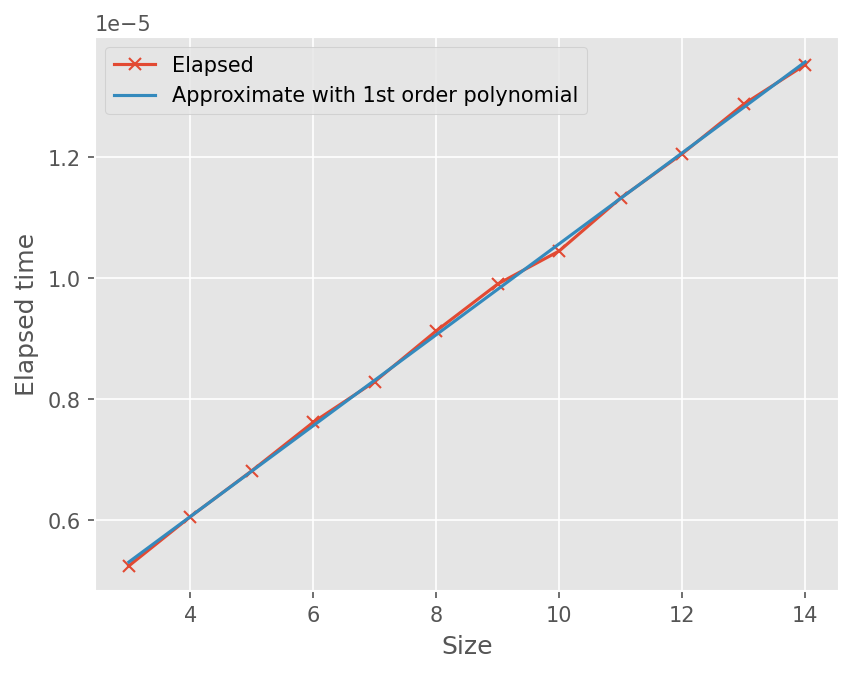

In [6]:
fig, ax = plt.subplots()
ax.plot(size, elapsed, marker='x')

# Approximate elapsed time with 1st order polynomial
z = np.polyfit(size, elapsed, 1)
appxf = np.poly1d(z)

ax.plot(size, appxf(size))
ax.legend(['Elapsed', 'Approximate with 1st order polynomial'])
ax.set_xlabel('Size')
ax.set_ylabel('Elapsed time')

### 예제
$\alpha=0.1$ 이고 $x\in [0, 1]$ 에 대해서 해석한다.

- 초기 조건 : $T(x,0) = 100$
- 경계 조건 : $T(0, t) = 0$, $T(1, t) = 300$

$\Delta x = 0.1$ 일 때 Backward Euler 기법으로 계산하면 다음과 같다.

Error: 1.67398


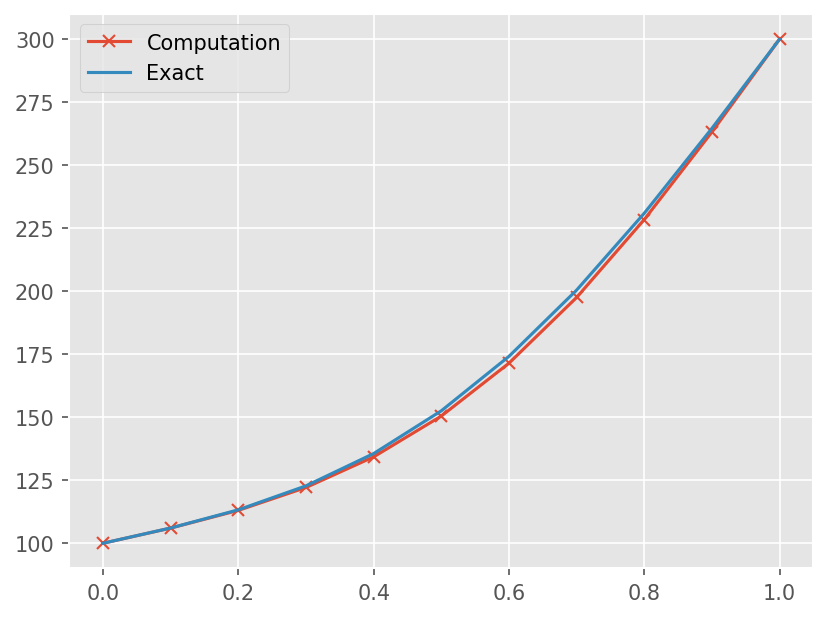

In [9]:
# Conditions
alpha = 0.1
ti = 100
ts = 300

t_target = 1.0
dt = 0.1

# Make grid
nx = 11
x = np.linspace(0, 1, nx)
dx = np.diff(x)[0]

# Const
beta = alpha*dt/dx**2

# Solution array
u = np.ones_like(x)*ti
d = np.empty_like(u[1:-1])

# Calculation
t = 0
while abs(t - t_target) > 1e-10:
    # Adjust time step to reach target time
    dt = min(dt, t_target - t)
    
    # right hand side
    d[:] = u[1:-1]
    
    # Apply bc
    u[0] = ti
    u[-1] = ts
    d[0] += beta*u[0]
    d[-1] += beta*u[-1]
    
    # Operation matrix
    a = c = -beta*np.ones(nx-3)
    b = (1+2*beta)*np.ones(nx-2)
    
    # Solve
    u[1:-1] = solve_tdiag(a, b, c, d)
    
    # Update solution and time
    t += dt

# Exact solution
dts = ts - ti
u_exact = ti + dts*x + np.sum([
    2*dts*(-1)**n / (n*np.pi) *np.exp(-n**2*np.pi**2*alpha*t)*np.sin(n*np.pi*x) 
    for n in range(1, 10)
], axis=0)

# Visualization
plt.plot(x, u, marker='x')
plt.plot(x, u_exact)
plt.legend(['Computation', 'Exact'])

# Compute Error
err = np.linalg.norm(u[1:-1] - u_exact[1:-1])
err = u - u_exact
err = np.sqrt(np.sum(err**2) / nx)
print('Error: {:.5f}'.format(err))

### (Optional) 실습

$\Delta x = 0.1$ 일 때 Crank Nicolson 방법으로 해석해보자.